In [1]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

import joblib
from utils import predict_xr

In [2]:
%reload_ext autoreload
%autoreload 2

## Find and load S2 data

Load data and set up your array to use for prediction

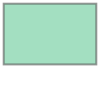

In [3]:
fiji_bbox = [177.347, -17.854, 177.591, -17.694]
fiji_bbox_geometry = geometry.box(*fiji_bbox)
fiji_bbox_geometry    

In [4]:
# Define collection
collection = "dep_s2_geomad"

# Define client (source)
client = Client.open("https://stac.staging.digitalearthpacific.org")

# Define items of collection
items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2023",
).items())

print(f"Found {len(items)} items")

Found 2 items


In [5]:
# Define S2 Bands

bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
    "emad",
    "bcmad",
    "smad",
]

# Define data variable

data = load(
    items,
    bbox=fiji_bbox,
    measurements=bands,
    resolution=10,
    chunks={"x": 2000, "y":2000, "time": np.atleast_1d(1),},
)

## Not sure whether to include the squeeze function 
# data = data.squeeze("time")

data
    

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables: (12/13)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    B8A          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B11          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    emad         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bcmad        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    smad         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>

In [6]:
# S2 indices

# ndvi
data["ndvi"] = (data["B08"] - data["B04"]) / (data["B08"] + data["B04"])

# mdnwi 
data["mndwi"] = (data["B03"] - data["B12"]) / (data["B03"] + data["B12"])

# evi
data["evi"] = (2.5*(data["B08"] - data["B04"]))*((data["B08"] + (6*(data["B04"]) - (7.5*(data["B02"])))))+1

# savi
data["savi"] = (data["B07"] - data["B04"]) / (data["B07"] + data["B04"] + 0.5*(1 + 0.5))

# bsi
data["bsi"] = ((data["B11"] + data["B04"]) - (data["B08"] + data["B02"])) / ((data["B11"] + data["B04"]) + (data["B08"] + data["B02"])) 

# ndmi 
data["ndmi"] = (data["B08"] - data["B11"]) / (data["B08"] + data["B11"])

# ndbi
data["ndbi"] = (data["B06"] - data["B05"]) / (data["B06"] + data["B05"])

In [7]:
# Check resulting dataset with newly included total now adding up to 20 data variables
data

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables: (12/20)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    mndwi        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    evi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    savi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bsi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndmi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndbi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>

## Find and load SRTM elevation data

In [8]:
# Get MPC authorisation / dependencies

from planetary_computer import sign_url
import os

# URL for STAC API

# Define catalogue
catalogue_dem = "https://planetarycomputer.microsoft.com/api/stac/v1/"

# Define collection
collection_dem = "cop-dem-glo-30"

# Define client 
client_dem = Client.open(catalogue_dem)

# Define bbox
fiji_bbox = [177.347, -17.854, 177.591, -17.694]

# Define items / pystac_client list
items_dem = list(client_dem.search(collections=[collection_dem], bbox=fiji_bbox).items())
print(len(items_dem))

1


In [9]:
# Authorised access to MPC data
os.environ["PC_SDK_SUBSCRIPTION_KEY"] = "84162f5502174b1b838239e74a44898d"

In [10]:
# Load dem data - 

# Loading dem data with args
data_dem = load(items_dem, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

# Loading data without NaN / nodata values of -32768) 
data_dem = data_dem.where(data_dem != -32768)

# data_dem = data_dem.squeeze("time").rename({"data":"elevation"})

# Renaming but not squeezing for time yet - need to check whether this is needed at all for any of the datasets
data_dem = data_dem.rename({"data":"elevation"})

data_dem

<xarray.Dataset>
Dimensions:      (time: 1, y: 1860, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2021-04-22
Data variables:
    elevation    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Merge S2 and srtm elevation

In [11]:
# After merging we should now have 21 data variables in the same order as the previous model / years. 
data_s2_dem = data.update(data_dem)
data_s2_dem

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
  * time         (time) datetime64[ns] 2023-01-01
    spatial_ref  int32 3832
Data variables: (12/21)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    evi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    savi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bsi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndmi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndbi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    elevation    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Find and load S1 data

In [12]:
# Dependencies - already completed above
# Authorisation - already completed above

# Define S1 catalog and open
catalog_s1 = "https://stac.staging.digitalearthpacific.org"
client = Client.open(catalog_s1)


In [13]:
# Define search parameters 
fiji_bbox = [177.347, -17.854, 177.591, -17.694]
datetime = "2023"

# Define pystac items list
items_s1 = list(client.search(collections=["dep_s1_mosaic"], bbox=fiji_bbox, datetime=datetime).items())
print(f"Found {len(items_s1)} items")


Found 2 items


In [14]:
# Data parameters

data_s1 = load(items_s1, bbox=fiji_bbox, resolution=10, chunks={"x":4000,"y":4000},)

data_s1 = data_s1.where(data_s1 != -32768)
               
data_s1

<xarray.Dataset>
Dimensions:      (time: 1, y: 1860, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables:
    count        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    std_vh       (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    std_vv       (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vh      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vv      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    median_vh    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    median_vv    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

In [15]:
# Define bands / indices
data_s1["mean_vv_vh"] = (data_s1["mean_vv"]) / (data_s1["mean_vh"])

In [16]:
# Define mean s1
mean_s1 = data_s1.mean(dim="time")
mean_s1["mean_vv_vh"] = mean_s1.mean_vv/mean_s1.mean_vh

In [17]:
# load s1 data 

data_s1 = load(
    items_s1,
    bbox=fiji_bbox,
    resolution=10,
    bands=["mean_vv","mean_vh"],
    chunks={"x":4000,"y":4000},
)#.squeeze("time") # cCommented out squeeze time to avoid subsequent error when merging datasets: error msg "time is already a scalar variable"

# Mask nodata values
data_s1 = data_s1.where(data_s1 != -32768)

# mean_vv_vh
data_s1["mean_vv_vh"] = data_s1.mean_vv / data_s1.mean_vh

# check resulting s1 dataset
data_s1

<xarray.Dataset>
Dimensions:      (time: 1, y: 1860, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables:
    mean_vv      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vh      (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>
    mean_vv_vh   (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Merge all datasets together for ML xarray

In [18]:
merged = data_s2_dem.update(data_s1).compute()

In [19]:
# check resulting dataset which should have 24 data variables
merged

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
  * time         (time) datetime64[ns] 2023-01-01
    spatial_ref  int32 3832
Data variables: (12/24)
    B02          (time, y, x) float32 1.406e+03 1.407e+03 ... 1.221e+03
    B03          (time, y, x) float32 1.257e+03 1.265e+03 ... 1.417e+03
    B04          (time, y, x) float32 1.125e+03 1.131e+03 ... 1.207e+03 1.2e+03
    B05          (time, y, x) float32 1.124e+03 1.131e+03 ... 1.756e+03
    B06          (time, y, x) float32 1.11e+03 1.113e+03 ... 3.254e+03 3.255e+03
    B07          (time, y, x) float32 1.117e+03 1.125e+03 ... 3.778e+03
    ...           ...
    ndmi         (time, y, x) float32 0.001364 -0.001361 ... 0.2399 0.2079
    ndbi         (time, y, x) float32 -0.006267 -0.008021 ... 0.2985 0.2991
    elevation    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    mean_vv      (time, y, x) float32 0.01451 0.01583 0.01457 ... 0.1974 0.1511
    mean_vh      (time, y, x) float32 0.004925 0.005292 ... 0.05143 0.03943
    mean_vv_vh   (time, y, x) float32 2.945 2.991 2.63 ... 3.843 3.838 3.834

## Run ML classifier

In [27]:
# Load in training data but do not use it to retrain model
training_file = "training_data/draft_inputs/MRD_dissagregated_20.geojson"

tdata = gpd.read_file(training_file, bbox=fiji_bbox_geometry)
tdata.explore()

projected_training_data = tdata.to_crs("EPSG:3832")

# Remove the ID field
# projected_training_data.drop(columns=["id"], inplace=True)

In [28]:
from tqdm import tqdm

training_array = []


projected_training_data = tdata.to_crs("EPSG:3832")


def get_training_data(id_row):
    _, row = id_row
    cls_id = row["lulc_code"]
    # id = row["id"]
    geom = row["geometry"]

    # Get xarray values at the point
    x = merged.sel(x=geom.x, y=geom.y, method="nearest")
    one_point = [cls_id] + [float(v) for v in x.values()]
    return one_point


with ThreadPoolExecutor(max_workers=10) as executor:
    training_array = list(
        tqdm(
            executor.map(get_training_data, projected_training_data.iterrows()),
            total=len(projected_training_data),
        )
    )

print(f"Fetched data for {len(training_array)} training points")

100%|██████████| 107/107 [00:00<00:00, 281197.07it/s]

Fetched data for 107 training points


In [29]:
classifer = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 1:]
classes = np.array(training_array)[:, 0]

model = "model_20230206.dump"
loaded_model = joblib.load("model_20230206.dump")

In [30]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3832")

ll = [-17.68786, 178.46045]
ur = [-17.60134, 178.55120]

ll_projected = transformer.transform(*ll)
ur_projected = transformer.transform(*ur)


predict_subset = merged.sel(
    x=slice(ll_projected[0], ur_projected[0]), y=slice(ur_projected[1], ll_projected[1])
)
# This one loads all the data from all Viti Levu
predict_subset = predict_subset.fillna(-9999)
predict_subset

<xarray.Dataset>
Dimensions:      (time: 1, y: 0, x: 0)
Coordinates:
  * y            (y) float64 
  * x            (x) float64 
  * time         (time) datetime64[ns] 2023-01-01
    spatial_ref  int32 3832
Data variables: (12/24)
    B02          (time, y, x) float32 
    B03          (time, y, x) float32 
    B04          (time, y, x) float32 
    B05          (time, y, x) float32 
    B06          (time, y, x) float32 
    B07          (time, y, x) float32 
    ...           ...
    ndmi         (time, y, x) float32 
    ndbi         (time, y, x) float32 
    elevation    (time, y, x) float32 
    mean_vv      (time, y, x) float32 
    mean_vh      (time, y, x) float32 
    mean_vv_vh   (time, y, x) float32

In [26]:
# This runs the actual prediction
predicted = predict_xr(loaded_model, predict_subset, proba=True)

# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

ValueError: Can't calculate resolution for empty data

In [ ]:
cleaned_predictions

In [31]:
from matplotlib import colors

classes = [
    [1, "bare_land", "#968640"],
    [2, "forest", "#064a00"],
    [3, "crops", "#ffce33"],
    [4, "grassland", "#d7ffa0"],
    [5, "settlements", "#b3b2ae"],
    [6, "mangroves", "#07b28d"],
    [7, "water", "#71a8ff"],
    [8, "quarry", "#b03a2e"]
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [9]
norm = colors.BoundaryNorm(bounds, c_map.N)

cleaned_predictions.lulc.plot.imshow(cmap=c_map, norm=norm, size=10)

NameError: name 'cleaned_predictions' is not defined

In [32]:
predict_subset[["B04", "B03", "B02"]].to_array().plot.imshow(size=8, vmin=0, vmax=3000)

TypeError: No numeric data to plot.